# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Funktionen definieren

In [2]:
def select_every_12th_with_start(arr, start_index):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 11")

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])
    
    return selected_elements

def linear_reg(x, m, t):
    return m*x + t

def generate_counting_array(length):
    return np.arange(length)

    
def selecting_month(arr, start_index, start_date, end_date):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 12")  # Change 11 to 12

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])

    tmp = xr.concat(selected_elements, dim="time")  # Concatenate the selected elements
    tmp = tmp.sel(time=slice(start_date, end_date))
    
    return tmp


def fit_count(arr):
    return generate_counting_array(len(arr))



def selecting_tf(arr,start_time, end_time):
    return arr.sel(time = slice(start_time, end_time))



## Daten importieren

In [3]:
# File paths
TMin_file = 'data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'data\cru_ts4.07.1901.2022.tmp.dat.nc\cru_ts4.07.1901.2022.tmp.dat.nc'

# Load datasets
TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg =  xr.open_dataset(TAvg_file)

## Differenz berechnen

In [4]:
#Projeziert auf eine latitude

TMin_Lat = TMin.mean('lon')
TMax_Lat = TMax.mean('lon')
TAvg_Lat = TAvg.mean('lon')

In [5]:
time_values = TMax['time'].values

In [6]:
TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')

In [7]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

## Plots

### Delta T

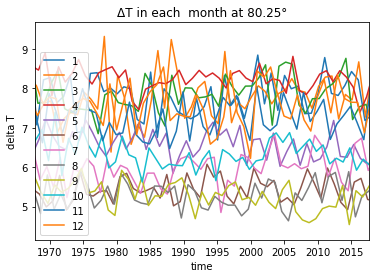

In [8]:
lat = 80.75

# Define the variables time_values and temperature_difference_Lat here

for month in range(1, 13):
    plt.plot(
        select_every_12th_with_start(time_values, month),
        select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month),
        label= str(month)
    )

plt.xlabel('time')
plt.ylabel('delta T')
plt.title('ΔT in each  month at 80.25°')

# Uncomment these lines if needed
plt.xlim(time_values[800], time_values[1400])
plt.legend(loc=3)

# plt.tight_layout()
# plt.savefig(f'Delta_T_Month_{month}.png', dpi=300)
# plt.clf()

plt.show()  # Display the plot


Text(0.5, 1.0, 'Mean Delta T for month at 80.25°')

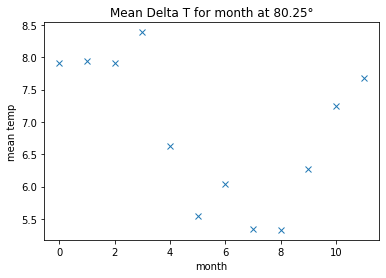

In [9]:
#Calculating the mean values for Delta T

lat = 80.25

mean_month =  np.array([[1, np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), 1))]])

for month in range(2,13):
    mean_month = np.vstack((mean_month,np.array([[month,np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month))]])) )

plt.plot(mean_month[:,1], ls = '', marker = 'x')

plt.xlabel('month')
plt.ylabel('mean temp')

plt.title('Mean Delta T for month at 80.25°')

Text(0.5, 1.0, 'Mean Delta T for month at 66.25°')

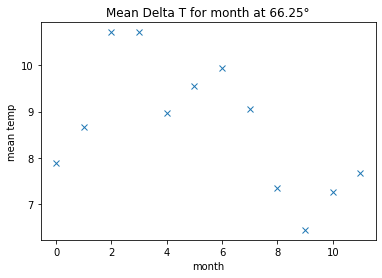

In [10]:
#Calculating the mean values for Delta T
lat = 66.25

mean_month =  np.array([[1, np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), 1))]])

for month in range(2,13):
    mean_month = np.vstack((mean_month,np.array([[month,np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month))]])) )

plt.plot(mean_month[:,1], ls = '', marker = 'x')

plt.xlabel('month')
plt.ylabel('mean temp')

plt.title('Mean Delta T for month at 66.25°')

### Plot Minimaltemperaturen

### Poly Fit Delta T


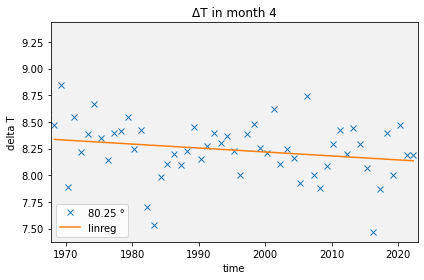

In [11]:
# Nach Jahreszeiten selektiert Januar
month = 4

lat = 80.25


paramet_fit_month4_lat8025, cov_month4_lat8025 = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:])

#print(type(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))[0]))

generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))* paramet_fit_month4_lat8025[0]


ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025)
plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month),marker = 'x', ls = '', label = str(lat)+' °')

plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Calculating varriance

VarDeltaT = np.var(select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:]-ydata_temp)


plt.xlabel('time')
plt.ylabel('delta T')

plt.title('ΔT in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)
# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_Delta_T.png', dpi = 300)
plt.show()

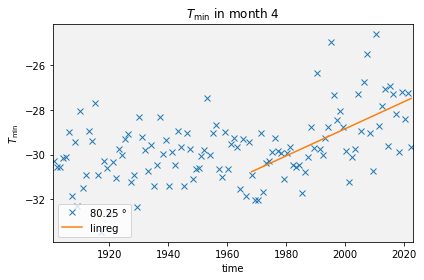

In [12]:
# Parameter setzen

month = 4
lat = 80.25

#Fitten

paramet_fit_month4_lat8025_minTemP, cov_month4_lat8025_MinTemp = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month)[67:])

#Plots vorbereiten

ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025_minTemP)

#Calculating Var

VarTMin = np.var(select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month)[67:] -ydata_temp)

#Plotten

plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month),marker = 'x', ls = '', label = str(lat)+' °')
plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Formatieren

plt.xlabel('time')
plt.ylabel('$T_{\mathrm{min}}$')

plt.title('$T_{\mathrm{min}}$ in month ' + str(month))

plt.xlim(time_values[0], time_values[-1])
plt.legend(loc = 3)

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_T_min.png', dpi = 300)
plt.show()

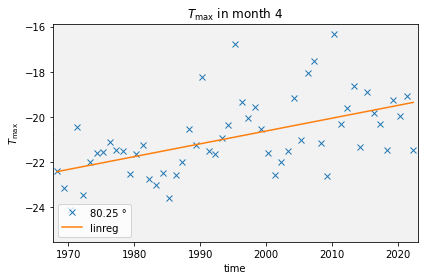

In [13]:
# Parameter setzen

month = 4
lat = 80.25

#Fitten

paramet_fit_month4_lat8025_maxTemP, cov_month4_lat8025_MaxTemp = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month)[67:])

#Plots vorbereiten

ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025_maxTemP)


#Calculating Var

VarTMax = np.var(select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month)[67:] -ydata_temp)

#Plotten

plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month),marker = 'x', ls = '', label = str(lat)+' °')
plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Formatieren

plt.xlabel('time')
plt.ylabel('$T_{\mathrm{max}}$')

plt.title('$T_{\mathrm{max}}$ in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_T_max.png', dpi = 300)
plt.show()

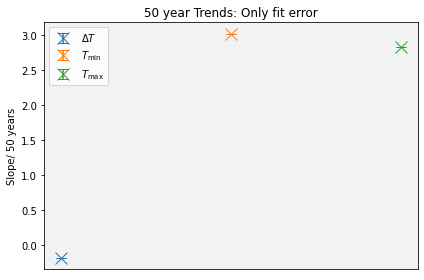

In [14]:
#Plot

# Data for the points
pos = np.array([1, 2, 3])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

# Error bars for the points
x_err = None
y_err = np.array([cov_month4_lat8025[0,0], cov_month4_lat8025_MinTemp[0,0], cov_month4_lat8025_MaxTemp[0,0]])*2.5

# cov_month4_lat8025_MinTemp
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the points with error bars
ax.errorbar(pos[0], slope[0], xerr=x_err, yerr=y_err[0], fmt='x', markersize=12, capsize=5, label='$\Delta T$')
ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=12, capsize=5, label='$T_{\mathrm{min}}$')
ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=12, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
plt.xticks([])  # Empty list for tick labels, tick marks remain visible

ax.set_ylabel('Slope/ 50 years')
ax.set_title('50 year Trends: Only fit error')

# Add legend
ax.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('50YearSlope_fiterror.png', dpi = 300)
plt.show()

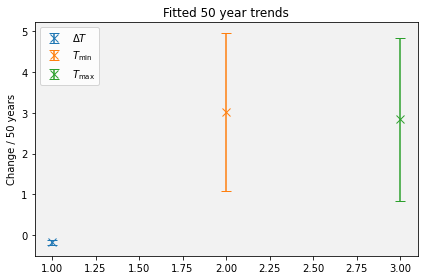

In [15]:
#Plot

# Data for the points
pos = np.array([1, 2, 3])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

# Error bars for the points
x_err = None
y_err = np.array([VarDeltaT, VarTMin, VarTMax])

# cov_month4_lat8025_MinTemp
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the points with error bars
ax.errorbar(pos[0], slope[0], xerr=x_err, yerr=y_err[0], fmt='x', markersize=8, capsize=5, label='$\Delta T$')
ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{min}}$')
ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
ax.set_ylabel('Change / 50 years')

ax.set_title('Fitted 50 year trends')

# Add legend
ax.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('50yearSlope_numErr.png',dpi = 300)
plt.show()

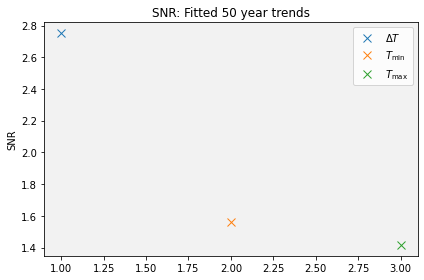

In [16]:
# SNR

y_err = np.array([VarDeltaT, VarTMin, VarTMax])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

SNR = np.divide(slope, y_err)

plt.plot(pos[0],-SNR[0], marker='x', markersize=8, ls = '',  label='$\Delta T$')
plt.plot(pos[1], SNR[1], marker='x', markersize=8, ls = '',   label='$T_{\mathrm{min}}$')
plt.plot(pos[2], SNR[2], marker='x', markersize=8, ls = '',   label='$T_{\mathrm{max}}$')
# ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{min}}$')
# ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
plt.ylabel('SNR')

plt.title('SNR: Fitted 50 year trends')

# Add legend
plt.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
#plt.savefig('50yearSlope_SNR.png',dpi = 300)
plt.show()

In [17]:
time_values[0]
t1 = '1973-01-15T00:00:00.000000000'

# def selecting_month_test(arr, month, start_date, end_date):
#     if start_index < 1 or start_index > 12:
#         raise ValueError("Start index must be between 1 and 11")

#     selected_elements = []
#     for i in range(start_index - 1, len(arr), 12):
#         selected_elements.append(arr[i])
#         tmp = selected_elements.sel(time = slice(start_date, end_date))
#     return tmp

# selecting_month2(temperature_difference_Lat.sel(lat = str(lat)),4, t1, time_values[-1])

### Loops Fit

<xarray.DataArray 'time' (time: 122)>
array(['1901-01-16T00:00:00.000000000', '1902-01-16T00:00:00.000000000',
       '1903-01-16T00:00:00.000000000', '1904-01-16T00:00:00.000000000',
       '1905-01-16T00:00:00.000000000', '1906-01-16T00:00:00.000000000',
       '1907-01-16T00:00:00.000000000', '1908-01-16T00:00:00.000000000',
       '1909-01-16T00:00:00.000000000', '1910-01-16T00:00:00.000000000',
       '1911-01-16T00:00:00.000000000', '1912-01-16T00:00:00.000000000',
       '1913-01-16T00:00:00.000000000', '1914-01-16T00:00:00.000000000',
       '1915-01-16T00:00:00.000000000', '1916-01-16T00:00:00.000000000',
       '1917-01-16T00:00:00.000000000', '1918-01-16T00:00:00.000000000',
       '1919-01-16T00:00:00.000000000', '1920-01-16T00:00:00.000000000',
       '1921-01-16T00:00:00.000000000', '1922-01-16T00:00:00.000000000',
       '1923-01-16T00:00:00.000000000', '1924-01-16T00:00:00.000000000',
       '1925-01-16T00:00:00.000000000', '1926-01-16T00:00:00.000000000',
       '1927-

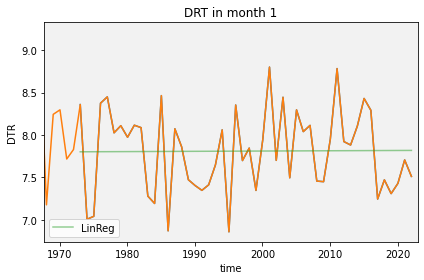

In [18]:
#Parameters
month = 1
lat = 80.25
t_s_d = '1901-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]

# Create an empty DataFrame
columns = ['month', 'slope', 'offset', 'var']
parameters_df = pd.DataFrame(columns=columns)

# Set 'month' as the index
parameters_df.set_index('month', inplace=True)


# Select data
y_data = selecting_month(temperature_difference_Lat.sel(lat = str(lat)),month, t_s_d, t_e)

#Selecting fitting data
y_temp = selecting_tf(y_data, t_s_f, t_e)
x_temp = fit_count(y_temp)

#Fitting
par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

#Producing fitting output
y_fit = linear_reg(x_temp, *par_LinReg)
x_fit = y_temp['time'].values


plt.plot(y_temp['time'].values, y_temp)
plt.plot(y_data['time'].values, y_data)
plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')
print(y_data['time'])

#Calculating Varriance

VarDeltaT = np.var(y_temp-y_fit)

#Adding to df
new_entry = {'slope': par_LinReg[0], 'offset': par_LinReg[1], 'var': VarDeltaT}
parameters_df.loc['1'] = new_entry


plt.xlabel('time')
plt.ylabel('DTR')

plt.title('DRT in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)
# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
#plt.savefig('Bilder/LinReg/LinReg_Delta_T_Month'+ str(month)+'.png', dpi = 300)
plt.show()



In [19]:
#Parameters
t_s_d = '1901-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]
month = 1


def LinReg_All_Month(arr, time_start_displayed, time_start_fit, time_end, Name):
    # Create an empty DataFrame
    columns = ['month', 'slope', 'offset', 'var']
    parameters_df = pd.DataFrame(columns=columns)

    # Set 'month' as the index
    parameters_df.set_index('month', inplace=True)

    for month in range(1,13):
        # Select data
        y_data = selecting_month(arr,month, time_start_displayed, time_end)

        #Selecting fitting data
        y_temp = selecting_tf(y_data, time_start_fit, time_end)
        x_temp = fit_count(y_temp)

        #Fitting
        par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

        #Producing fitting output
        y_fit = linear_reg(x_temp, *par_LinReg)
        x_fit = y_temp['time'].values


        # #plt.plot(y_temp['time'].values, y_temp)
        # plt.plot(y_data['time'].values, y_data, marker = 'x', ls = '', label = 'data')
        # plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')

        #Calculating Varriance

        VarDeltaT = np.var(y_temp-y_fit)

        #Adding to df
        new_entry = {'slope': par_LinReg[0]*50, 'offset': par_LinReg[1], 'var': VarDeltaT.values}
        parameters_df.loc[str(month)] = new_entry


        # plt.xlabel('time')
        # plt.ylabel('DTR')

        # plt.title(Name + 'entire pol. reg. in month ' + str(month))

        # plt.xlim(time_values[800], time_values[-1])
        # plt.legend()
        # # Add a subtle background color
        # plt.gca().set_facecolor((0.95, 0.95, 0.95))

        # # Display the plot
        # plt.tight_layout()
        # plt.savefig('Bilder/LinReg/LinReg_'+Name+'_Month_'+ str(month)+'.png', dpi = 300)
        # plt.clf()
    return parameters_df


    

In [20]:
parameters_TDiff = LinReg_All_Month(temperature_difference_Pol, t_s_d, t_s_f, t_e, 'DTR')
parameters_TMax = LinReg_All_Month(TMax_Lat_tot.tmx, t_s_d, t_s_f, t_e, 'TMax')
parameters_TMin = LinReg_All_Month(TMin_Lat_tot.tmn, t_s_d, t_s_f, t_e, 'TMin')

In [21]:
parameters_TDiff['SNR'] =np.abs(parameters_TDiff['slope']/parameters_TDiff['var'])
parameters_TMax['SNR'] = np.abs(parameters_TMax['slope']/parameters_TMax['var'])
parameters_TMin['SNR'] = np.abs(parameters_TMin['slope']/parameters_TMin['var'])

In [22]:
parameters_TMax


,slope,offset,var,SNR
month,,,,
1,2.511288,-28.167039,2.006776048100829,1.251404
2,2.779035,-28.885241,2.5018664479384913,1.110785
3,2.696680,-26.148470,1.0814852569319295,2.493497
4,2.490328,-18.066863,1.0964761848763194,2.27121
5,1.606928,-6.961032,0.5138713035454453,3.127102
6,1.798747,1.914238,0.34301612593337394,5.243914
7,1.244855,6.189663,0.181593865498101,6.85516
8,1.337272,3.763644,0.27323952081667036,4.894138
9,1.675114,-4.100255,0.39087464700907565,4.285553


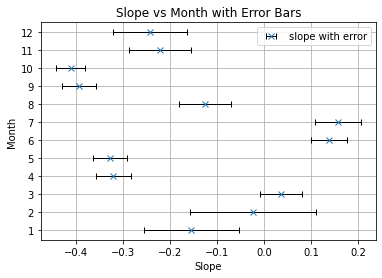

In [23]:
# Create the plot
plt.errorbar(parameters_TDiff['slope'], parameters_TDiff.index, xerr=parameters_TDiff['var'], fmt='x', capsize= 3,ecolor= 'black', elinewidth=1, label='slope with error')
plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

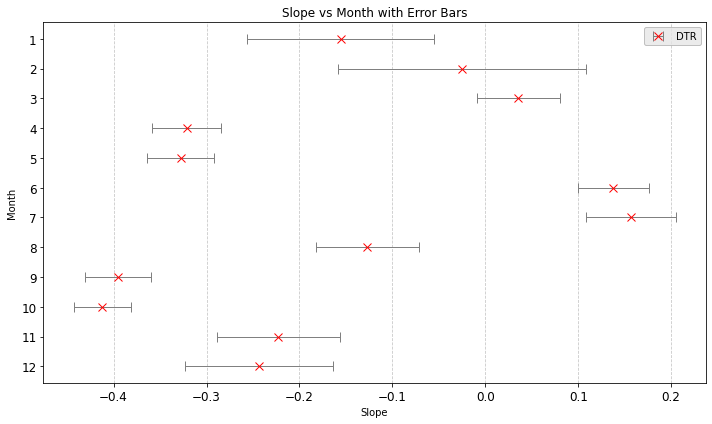

In [24]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TDiff['slope'], parameters_TDiff.index, color = 'r',
    xerr=parameters_TDiff['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='DTR'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

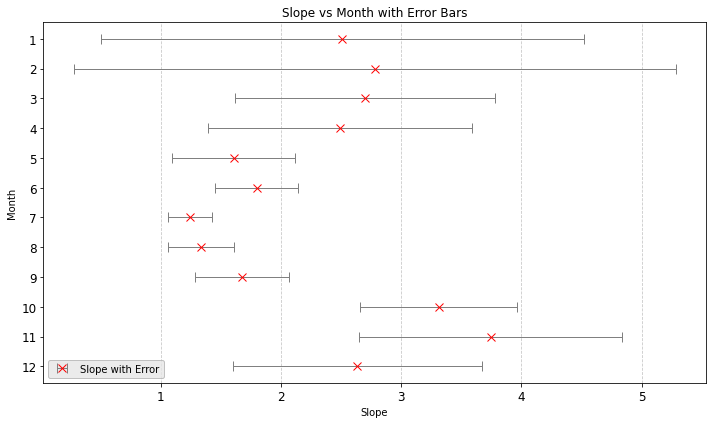

In [25]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'r',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

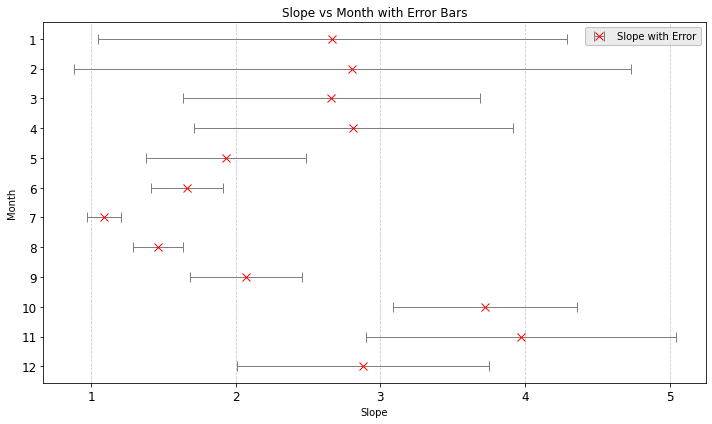

In [26]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

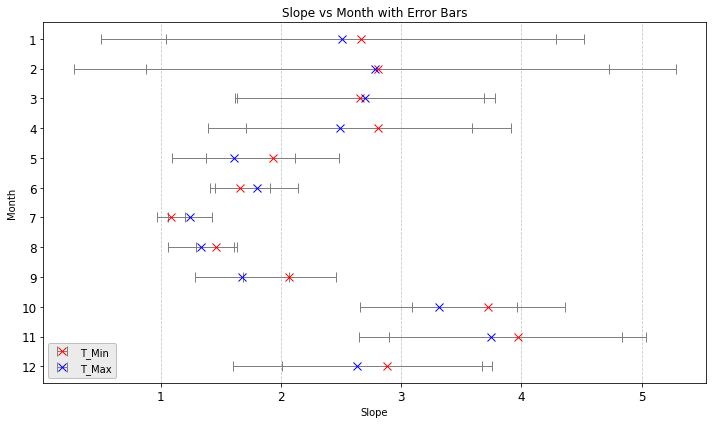

In [27]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'b',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='b', markeredgewidth=1, label='T_Max'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

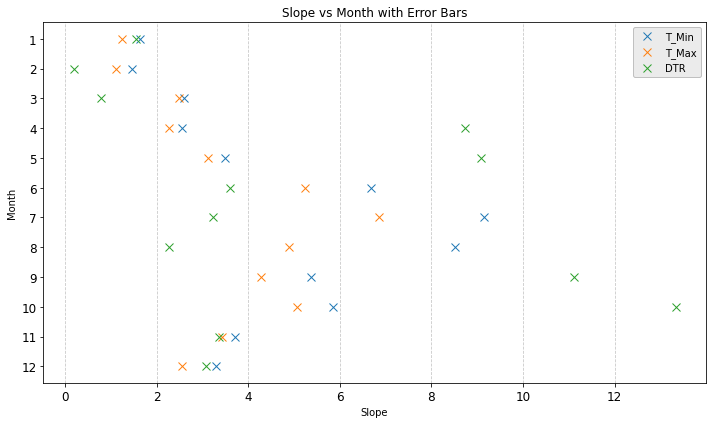

In [28]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['SNR'], parameters_TMin.index,
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['SNR'], parameters_TMax.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Max'
)

plt.errorbar(
    parameters_TDiff['SNR'], parameters_TDiff.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='DTR'
)


plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

### Hearmap

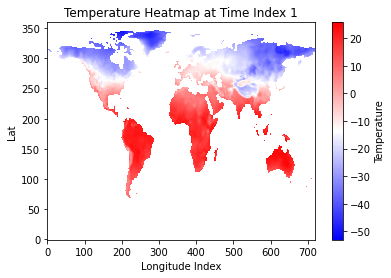

In [29]:
time_index = 1
temperature_data = TMin.isel(time=time_index).tmn#,lon = range(0,260), lat = range(330,360)).tmn

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title(f'Temperature Heatmap at Time Index {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Lat')
plt.show()